# Round 4: More Advanced Imputation of Age:

In the previous rounds, we filled in missing Age data by just using the average. I want to try a more nuanced approach. Maybe we can guess missing Age data by title. For example, it was often the case that women in the era we are considering married younger. Therefore unmarried women going by the title "Miss" may have been, on average, younger than those going by the title "Mrs". We also know that it was more socially acceptable for young women to marry older men, meaning that passengers with the title "Mr" might be older than their female counterparts. Let's see if the data supports our idea.

If you are following along in this notebook, you may notice that we have already filled in missing Age data. In order to get to a state where we have 'Title' information but have _not_ filled in the missing age data, we will have to re-run some cells from Stage 1 and Stage 3. 

Run our previous steps in this order:

__1.__ Load the data (Stage 1)

__2.__ Add the 'Title' Feature (Stage 3)

__3.__ Map similar titles (Stage 3)

__4.__ Factorize the 'Title' feature (Stage 3)

__5.__ Factorize all other categorical data (Stage 1)

__6.__ Standardize the continuous data (Stage 1)


Once we have re-run these steps, our data will be in a state where the missing age data has not been filled in yet, but we have our title information:

In [662]:
train_df.Age.isnull().value_counts()

False    714
True     177
Name: Age, dtype: int64

In [663]:
train_df.Title.value_counts()

0    517
2    185
1    126
3     40
5     18
4      3
6      2
Name: Title, dtype: int64

Now that we are where we need to be with our data, let's visualize the distribution of our passengers by title and age:

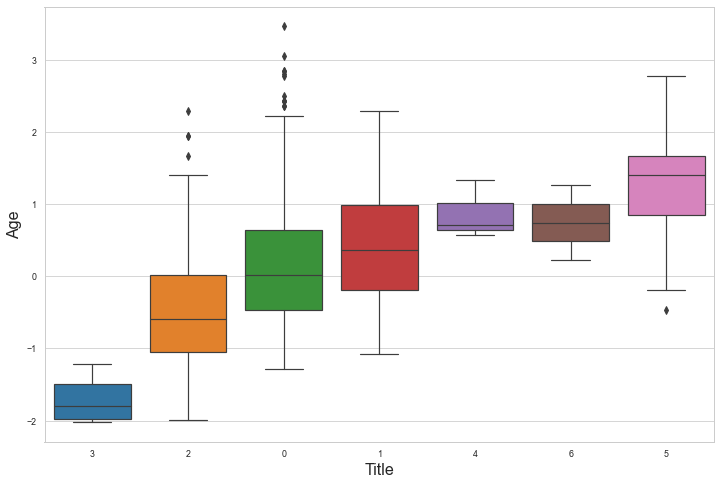

In [664]:
# Sort titles by median age for visual display:
titles = pd.Series(train_df.Title.unique(), name="Title")
medians = []
for title in titles:
#     print(title)
    title_med = train_df.loc[train_df.Title == title, 'Age'].median()
    medians.append(title_med)

titles = pd.concat([titles, pd.Series(medians, name='Medians')], axis=1).sort_values(by='Medians')

#Plot boxplot sorted by median age of title:

sns.boxplot(x='Title', y='Age', data=train_df, order = titles.index)

So it does indeed look like there is a relative order to the median age of a given title. Let's use this information to fill the missing age data, and see if it improves our scores over just using the average of all ages. 

In [665]:
for title in train_df.Title.unique():
    median = train_df.loc[train_df.Title == title, 'Age'].median()
    train_df.loc[train_df.Age.isnull() & (train_df.Title == title), 'Age'] = median

In [666]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    int64  
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    int64  
 11  Title     891 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 130.5+ KB


We now see that all 891 entries for age have been filled in. It's time to go ahead and split our data again, and train our model.

In [667]:
# Split data again. We should get the same split as last time by using the same random seed:
np.random.seed(333)

X = train_df.drop(['Survived'], axis=1)
Y = train_df.Survived

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2)
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train, test_size=0.2)

x_train.sort_values(by='PassengerId').head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",0,-0.530377,0,0,A/5 21171,-0.502445,NaN,0,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.571831,0,0,PC 17599,0.786845,C85,1,1
3,0,"Heikkinen, Miss. Laina",1,-0.254825,1,0,STON/O2. 3101282,-0.488854,NaN,0,2
5,0,"Allen, Mr. William Henry",0,0.365167,1,0,373450,-0.486337,NaN,0,0
7,1,"McCarthy, Mr. Timothy J",0,1.674039,1,0,17463,0.395814,E46,0,0
11,0,"Sandstrom, Miss. Marguerite Rut",1,-1.770360,0,1,PP 9549,-0.312172,G6,0,2
12,1,"Bonnell, Miss. Elizabeth",1,1.949591,1,0,113783,-0.113846,C103,0,2
14,0,"Andersson, Mr. Anders Johan",0,0.640719,0,3,347082,-0.018709,NaN,0,0
15,0,"Vestrom, Miss. Hulda Amanda Adolfina",1,-1.081480,1,0,350406,-0.490280,NaN,0,2


In [668]:
# drop name, cabin, ticket and embarked
for item in ('Cabin', 'Ticket', 'Embarked', 'Name'):
    x_train = x_train.drop([item], axis=1)
    x_test = x_test.drop([item], axis=1)
    x_valid = x_valid.drop([item], axis=1)

# see if classes were droped:
x_train 

,Pclass,Sex,Age,SibSp,Parch,Fare,Title
PassengerId,,,,,,,
294,0,1,-0.392601,1,0,-0.470230,2
426,0,0,0.020727,1,0,-0.502445,0
499,1,1,-0.323713,0,2,2.402990,1
91,0,0,-0.048161,1,0,-0.486337,0
227,2,0,-0.737041,1,0,-0.437007,0
...,...,...,...,...,...,...,...
147,0,0,-0.185937,1,0,-0.491456,0
762,0,0,0.778495,1,0,-0.504962,0
835,0,0,-0.805929,1,0,-0.481304,0


In [669]:
# Run model on new data:

models['Logistic Regression 4'] = evaluate(linear_model.LogisticRegression())
models['Logistic Regression 4']['Notes'] = 'Imputed age from title features median age'

# compare this iteration with current best:
pprint(models['Logistic Regression 3'])
pprint(models['Logistic Regression 4'])

 Died: 
	 precision :  0.8315789473684211
	 recall :  0.8977272727272727
	 f1-score :  0.8633879781420765
	 support :  88
 Survived: 
	 precision :  0.8125
	 recall :  0.7090909090909091
	 f1-score :  0.7572815533980584
	 support :  55
 accuracy :  0.8251748251748252
 macro avg: 
	 precision :  0.8220394736842105
	 recall :  0.803409090909091
	 f1-score :  0.8103347657700675
	 support :  143
 weighted avg: 
	 precision :  0.8242408906882591
	 recall :  0.8251748251748252
	 f1-score :  0.8225778147789926
	 support :  143
 AUC :  0.8055785123966942
 Classifier :  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
 Notes :  Added 'Title' feature. No resampling. No Tuning
 Died: 
	 precision :  0.8229166666666666
	 reca

## Round 4 Performance:

Well, surprisingly, it looks like our model did better when we just filled in missing age with the average of all the ages. That's a little disappointing. 